# 卷积层
![convolution](./convolution.png)

**位于给定层的第i行第j列的神经元连接到位于第i到i+f<sub>h</sub>-1行、第j到第f<sub>w</sub>-1列的前一层中的神经元的输出，其中f<sub>h</sub>和ff<sub>w</sub>是接受野的高度和宽度。**

![convolution](./convolution2.png)

**从一个接受野移到另一个接受野的距离称为步幅。在该图中使用3x3的接受野和为2的步幅，将5x7的输入层(加上零填充)连接到3x4的层。**

## 滤波器
神经元的权重可以表示为一小幅图像，其大小相当于接受野的大小。例如图14-5显示了两个可能的权重集，称为滤波器(卷积核)。第一个表示一个黑色的正方形，中间有一条垂直的白线(这是一个7x7的矩阵，全为0，除了中间那一列全为1)。使用这些权重的神经元将忽略其接受野中除中心垂线以外的所有内容。![filter](./filter.png)

## 堆叠多个特征图
实际上卷积层具有多个滤波器(你可以决定多少个)并为每个滤波器输出一个特征图，因此可以更精确的以3D模式显示。它在每个特征图中每个像素有一个神经元，给定特征图中的所有神经元共享相同的参数(权重和偏置)。不同特征图中的神经元使用不同的参数。神经元的接受野与先前描述的相同，但是它扩展到了所有先前层的特征图。

输入图像也由多个子层组成：每个颜色通道一个子层。通常有三种：红色、绿色和蓝色。

![convolution](./convolution3.png)

## Tensorflow实现
- 每个输入图像通常表示为形状为[height,width,channels]的3D张量。
- 小批量表示为形状为[mini batch size,height,width,channels]的4D张量。
- 卷积层的权重表示为形状为[f<sub>h</sub>,f<sub>w</sub>,f<sub>n'</sub>,f<sub>n</sub>]的4D张量。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from sklearn.datasets import load_sample_image

In [2]:
china=load_sample_image('china.jpg')/255
flower=load_sample_image('flower.jpg')/255
images=np.array([china,flower])
batch_size,height,width,channels=images.shape

In [3]:
images.shape

(2, 427, 640, 3)

In [4]:
# 创建两个滤波器
filters=np.zeros(shape=(7,7,channels,2),dtype=np.float32)
filters[:,3,:,0]=1 # 垂直滤波器
filters[3,:,:,1]=1 # 水平滤波器

In [5]:
outputs=tf.nn.conv2d(images,filters,strides=1,padding='SAME')

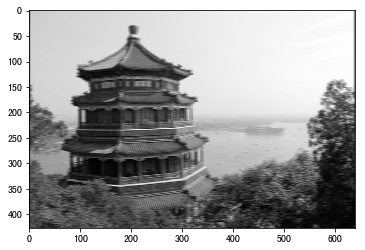

In [6]:
plt.imshow(outputs[0,:,:,1],cmap='gray')
plt.show()

- 每个颜色通道像素强度从0-255的字节。
- 然后我们创建两个7x7的滤波器（一个中间带有垂直白线，另一个在中间带有水平白线）。
- 我们使用tf.nn.conv2d()函数应用于两个图像。
- 最后绘制一个结果特征图。

解释tf.nn.conv2d()函数
- images是输入图像的小批量(4D张量)。
- filter是要应用的一组滤波器(4D张量)。
- strides步幅等于1。
- padding必须为"SAME"或者"VALID"：
    - 如果设置为"SAME"，则卷积层在必要时使用零填充。将输出大小设置为输入神经元的数量除以步幅(向上取整)所得的值。
    - 如果设置为"VALID"，则卷积层将不再使用零填充，并且可能会忽略输入图像底部和右侧的某些行和列，具体取决于步幅。
    - 通常，我们希望输出图像与输入图像的大小相同。因此需要在图像周围添加零，让我们可以在更多位置叠加过滤器。

在此实例中，我们手动定义了滤波器，但在实际的CNN中，通常将滤波器定义为可训练变量，以便神经网络可以了解哪种滤波器更好。

In [7]:
conv=keras.layers.Conv2D(filters=32,kernel_size=3,strides=1,padding="SAME",activation='relu')

该段代码使用步幅为1和零填充，创建了一个含有32个滤波器(每个3x3)的Conv2D层，并将ReLU激活函数应用于其输出。稍后我们会讨论通用的CNN架构。

## 内存需求
CNN的另一个问题是卷积层需要大量的RAM。

# 池化层
池化层没有权重，它所做的所有工作就是使用聚合函数来聚合输入。![pooling](./pooling.png)

池化层通常独立地作用于每个输入通道，因此输出深度与输入深度相同。

## TensorFlow实现
以下代码使用2x2内核创建了一个最大池化层。步幅默认为内核大小，因此该层将使用步幅2。默认情况下，它使用VALID填充。

In [8]:
max_pool=keras.layers.MaxPool2D(pool_size=2)

In [9]:
def crop(images):
    return images[150:220, 130:250]

In [10]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

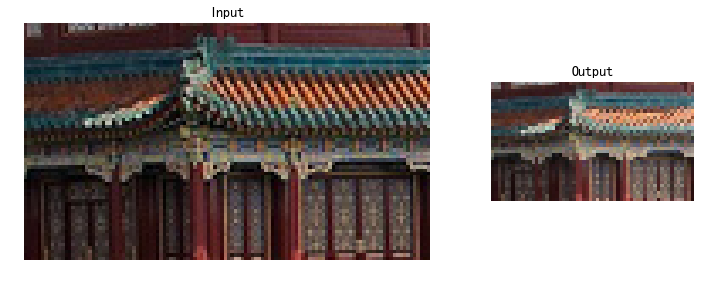

In [11]:
import matplotlib as mpl
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

要创建平均池化层，只需要使用AvgPool2D即可。最大池化层仅保留最强特征，将无意义的特征都丢掉，因此下一层可获得更加清晰的信号来使用。而且最大池化层提供了更强的变换不变性，通常表现更好。

在现代架构中经常会看到一种类型的池化层是全局平均池化层。它的工作原理非常不同：它所做的是计算整个特征图的均值。这就意味着每个特征图和每个实例只输出一个单值。尽管这极具破坏性，但是可以作为输出层。

In [12]:
gobal_avg_pool=keras.layers.GlobalAvgPool2D()

# CNN架构
典型的CNN架构堆叠了一些卷积层(通常每个卷积层都跟随了一个ReLU层)，然后是一个池化层，然后是另外几个卷积层(+ReLU)，然后是另一个池化层，依次类推。随着卷积网络的不断发展，图像变得越来越小，但是由于卷积层的存在，图像通常也越来越深。在堆栈的顶部添加了一个常规的前馈神经网络，该神经网络由几个全连接层(+ReLU)组成，最后一层输出预测。![CNN](./CNN.png)

In [13]:
from keras.datasets.fashion_mnist import load_data
(X_train_full, y_train_full), (X_test, y_test) = load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]
# np.newaxis的作用是增加一个维度。

In [14]:
X_train.shape

(55000, 28, 28, 1)

In [15]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(64,7,activation='relu',padding='SAME',input_shape=[28,28,1]))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Conv2D(128,3,activation='relu',padding='SAME'))
model.add(keras.layers.Conv2D(128,3,activation='relu',padding='SAME'))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Conv2D(256,3,activation='relu',padding='SAME'))
model.add(keras.layers.Conv2D(256,3,activation='relu',padding='SAME'))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(64,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10,activation='softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 256)         5

In [17]:
model.compile(optimizer='nadam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [18]:
# model.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=10)

In [19]:
model=keras.models.load_model(filepath='./myConvolutionNetwork.h5')

In [20]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 19s 26ms/step - loss: 0.3068 - accuracy: 0.9070


[0.30683058500289917, 0.9070000052452087]

让我们看一下这个模型：
- 第一层使用了64个相当大的滤波器(7x7),但没有步幅，因为输入图像不是很大。设置了input_shape=[28,28,1]，因为图像是28x28像素，具有单个颜色通道。
- 接下来我们有一个最大池化层，池化大小为2，因此它将内个维度空间除以2.
- 然后我们重复相同的结构两次:两各卷积层，紧接着是一个最大池化层。对于较大的图像我们可以重复此结构多次。
- 随着CNN向输出层延伸，滤波器的数量会增加：增长是有意义的，因为低层的特征数量会很少(例如小圈圈和水平线)，但是有很多方法可以把他们组合成高层次的特征。通常做法是在池化层后将滤波器的数量加倍。
- 接下来是全连接网络，该网络由两个隐藏的密集层和一个输出层组成。

## LeNet-5

## AlexNet

## GoogLeNet

## VGGNet

## ResNet
在训练神经网络时，目标使其成为目标函数h(x)的模型。如果输入x添加到网络的输出(即跳过连接)，则网络将被迫建模f(x)=h(x)-x而不是h(x)。这称为残差学习。![Residual learning](./residual.png)

如果添加许多跳过连接，即使几层还没有开始学习，网络也可以开始取得进展。借助跳过连接，信号可以轻轻松松地在整个网络中传播，深度残差网络可以看做是残差单元的堆栈，其中每个残差单元都是具有跳过连接的小型神经网络。

**ResNet结构**
![Residual architecture](./residual2.png)

## Xception

## SENet

# 使用keras实现ResNet-34
**首先创建一个ResidualUnit层。**

In [21]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self,filters,strides=1,activation='relu',**kwargs):
        super().__init__(**kwargs)
        self.activation=keras.activations.get(activation)
        self.main_layers=[
            keras.layers.Conv2D(filters,3,strides=strides,padding='SAME',use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters,3,strides=1,padding='SAME',use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers=[]
        if strides>1:
            self.skip_layers=[
                keras.layers.Conv2D(filters,1,strides=strides,padding='SAME',use_bias=False),
                keras.layers.BatchNormalization()]
            
    def call(self,inputs):
        Z=inputs
        for layer in self.main_layers:
            Z=layer(Z)
        skip_Z=inputs
        for layer in self.skip_layers:
            skip_Z=layer(skip_Z)
        return self.activation(Z+skip_Z)

在构造函数中我们创建所需要的层：主要层在图的右侧，而跳过层在图的左侧(仅当步幅大于1时才需要)。然后再call()方法中，使输入经过主要层和跳过层，然后添加输出层并应用激活函数。

**接下来我们可以使用Sequential模型来构建ResNet-34，因为它实际上只是一个很长的层序列：**

In [22]:
[64]*3+[128]*4+[256]*6+[512]*3

[64, 64, 64, 128, 128, 128, 128, 256, 256, 256, 256, 256, 256, 512, 512, 512]

In [23]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(64,7,strides=2,input_shape=[224,224,3],padding='SAME',use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size=3,strides=2,padding='SAME'))
pre_filters=64
for filters in [64]*3+[128]*4+[256]*6+[512]*3:
    strides=1 if filters==pre_filters else 2
    model.add(ResidualUnit(filters,strides=strides))
    pre_filters=filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10,activation='softmax'))

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

# 使用keras的预训练模型
通常你无须手动实现像GoogleNet或者ResNet这样的标准模型，因为在keras.applications包中只需一行代码即可得到预训练的网络。例如,以下代码加载在ImageNet上预训练的ResNet-50模型。

In [25]:
model=tf.keras.applications.resnet50.ResNet50(weights='imagenet')

要使用它，首先需要确保图像尺寸合适。ResNet-50模型需要224x224像素的图像。我们用Tensorflow的tf.image.resize()函数调整我们之前加载的图像的大小。

In [26]:
images_resized=tf.image.resize(images,[224,224])

In [27]:
images_resized.shape

TensorShape([2, 224, 224, 3])

tf.image.resize()不会保留宽高比，请在调整大小之前尝试将图像剪裁为适当的宽高比。两种操作可以使用tf.image.crop_and_resize()一次完成。

训练的模型以特定的方式对图像进行预处理。每个模型都提供一个preprocess_input()函数，你可以用来预处理图像。这些函数假定像素值得范围是0到255，因此我们必须把它乘255(之前除以255)。

In [28]:
inputs=tf.keras.applications.resnet50.preprocess_input(images_resized*255)

现在我们可以预测了。

In [29]:
y_proba=model.predict(inputs)

In [30]:
y_proba

array([[2.0924722e-08, 6.2120357e-08, 3.4899838e-08, ..., 3.0701273e-09,
        1.3317400e-07, 8.0284899e-08],
       [5.9666363e-08, 4.5356748e-05, 2.2303718e-07, ..., 3.2242751e-05,
        2.9164674e-03, 1.0851736e-05]], dtype=float32)

通常predict输出的是一个矩阵，每个图像一行，每个类一列。如果要显示前K个预测(包括类名和每个预测的概率)，请使用decode_predictions()函数。对于每个图像，它返回一个包含前K个预测的数组，其中每个预测都表示为一个包含类标识符、其名称和对应置信度得分的数组：

In [31]:
top_K=tf.keras.applications.resnet50.decode_predictions(y_proba,top=5)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id,name,y_probability in top_K[image_index]:
        print(" {} - {:12s} {:.2f}%".format(class_id,name,y_probability*100))
    print()

Image #0
 n02825657 - bell_cote    82.35%
 n03877845 - palace       6.75%
 n03781244 - monastery    4.19%
 n02980441 - castle       3.16%
 n03028079 - church       1.00%

Image #1
 n03530642 - honeycomb    49.81%
 n13040303 - stinkhorn    33.96%
 n02206856 - bee          4.35%
 n11939491 - daisy        3.23%
 n12985857 - coral_fungus 2.66%



但是，如果你要将图像分类器用于不属于ImageNet的图像类，该怎么办？在这种情况下，你仍然可以从预先训练的模型中受益，以进行迁移学习。

# 迁移学习的预训练模型
例如我们来训练模型对花的图片进行分类，并使用预训练的Xception模型。首先，让我们使用TensorFlow Datasets加载数据集。

In [32]:
import tensorflow_datasets as tfds

In [33]:
dataset,info=tfds.load('tf_flowers',as_supervised=True,with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling tf_flowers-train.tfrecord...:   0%|          | 0/3670 [00:00<?, ? examples/s]

Dataset tf_flowers downloaded and prepared to C:\Users\10093\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [34]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='C:\\Users\\10093\\tensorflow_datasets\\tf_flowers\\3.0.1',
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [35]:
dataset_size=info.splits["train"].num_examples
class_names=info.features['label'].names
n_classes=info.features['label'].num_classes

请注意你可以设置with_info=True获得有关数据的信息。接下来我们拆分验证集和测试集。

In [37]:
(test_set,valid_set,train_set)=tfds.load('tf_flowers',split=["train[:10%]","train[10%:15%]","train[90%:]"],as_supervised=True)

接下来我们必须对图像进行预处理，CNN需要224x224的图像，因此我们需要调整它们的大小。

In [40]:
def preprocess(image,label):
    resized_image=tf.image.resize(image,[224,224])
    final_image=tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image,label

用这个预处理函数来处理数据集。

In [41]:
batch_size=32
train_set=train_set.shuffle(1000)
train_set=train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set=valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set=test_set.map(preprocess).batch(batch_size).prefetch(1)

接下来我们加载一个在ImageNet上预训练的Xeception模型。我们通过设置include_top=False排除网络的顶部:这排除了全局平均池化层和密集输出层。然后根据基本输出添加一个我们自己的全局平均池化层，再跟一个每一个类一个单位的密集输出层，最后创建keras模型。

In [47]:
# base_model = tf.keras.applications.xception.Xception(weights="imagenet",
#                                                   include_top=False)
# avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
# output = keras.layers.Dense(n_classes, activation="softmax")(avg)
# model = keras.models.Model(inputs=base_model.input, outputs=output)

**这部分由于Tensorflow和keras版本问题均不能运行。所以不做展示，只给出代码。**

编译模型并开始训练。

In [48]:
# optimizer=keras.optimizers.SGD(learning_rate=0.01,momentum=0.9,decay=0.001)
# model.compile(optimizer=optimizer,loss=keras.losses.sparse_categorical_crossentropy,metrics=['accuracy'])
# history=model.fit(train_set,epochs=5,validation_data=valid_set)

对模型训练几个轮次之后，其验证精度应达到75%-80%，并且不再取得任何进展。这意味着顶层现在已经收到了良好的训练，因此我们解冻所有的层并继续进行训练(别忘了再次编译模型)。这次我们使用低得多的学习率来避免损坏预训练的权重。

In [49]:
# for layer in base_model.layers:
#     layer.trainable=True

# 分类和定位
定位图片可以表示为回归任务:预测物体周围的边界框，一种常见的方法是预测物体中心的水平坐标和垂直坐标，还有其高度和宽度。这意味着我们有四个需要输出。不需要对上面代码做出太多修改，我们只需要添加具有四个单位的第二个密集输出层，就可以使用MSE损失对其进行训练。

In [53]:
import keras.applications.xception
base_model=keras.applications.xception.Xception(weights='imagenet',include_top=False)
avg=keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output=keras.layers.Dense(n_classes,activation='softmax')(avg)
loc_ouput=keras.layers.Dense(4)(avg)

In [54]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.001), loss=[
              'sparse_categorical_crossentropy', 'mse'], loss_weights=[0.8, 0.2])

In [55]:
history=model.fit(train_set,epochs=5,validation_data=valid_set)

Epoch 1/5
12/12 [==============================] - 109s 9s/step - loss: 2.7013 - val_loss: 8.0107
Epoch 2/5
12/12 [==============================] - 127s 11s/step - loss: 0.2834 - val_loss: 9.7730
Epoch 3/5
12/12 [==============================] - 132s 11s/step - loss: 0.2830 - val_loss: 3.4752
Epoch 4/5
12/12 [==============================] - 135s 11s/step - loss: 0.0995 - val_loss: 3.4720
Epoch 5/5
12/12 [==============================] - 139s 12s/step - loss: 0.0430 - val_loss: 2.1318


In [56]:
for layer in base_model.layers:
     layer.trainable=True

In [57]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.003, momentum=0.9, decay=0.001), loss=[
              'sparse_categorical_crossentropy', 'mse'], loss_weights=[0.8, 0.2])

In [58]:
history=model.fit(train_set,epochs=5,validation_data=valid_set)

Epoch 1/5
12/12 [==============================] - 129s 11s/step - loss: 0.0347 - val_loss: 1.8737
Epoch 2/5
12/12 [==============================] - 138s 12s/step - loss: 0.0085 - val_loss: 2.1585
Epoch 3/5
12/12 [==============================] - 139s 12s/step - loss: 0.0059 - val_loss: 2.0796
Epoch 4/5
12/12 [==============================] - 139s 12s/step - loss: 0.0100 - val_loss: 1.8702
Epoch 5/5
12/12 [==============================] - 142s 12s/step - loss: 0.0042 - val_loss: 2.0866


# 物体检测

# 全卷积网络

# YOLO

# 语义分割